In [1]:
import pandas as pd
import numpy as np
import pickle
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

/Users/dirk/Anaconda/anaconda3/envs/nd025/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read the cleaned dataset
df = pd.read_parquet('./data/cleaned_dataset.parquet')

In [3]:
df.sample(10)

,MESS_DATUM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,MONTH,SEASON
143516,1986-11-18,10.0,0.0,6.0,6.5,0.0,1.7,8.2,1016.2,9.0,71.0,11.5,6.8,4.5,11,Autumn
218158,2017-04-14,10.0,0.0,6.0,4.5,0.0,5.7,7.3,1003.7,8.6,67.0,13.5,4.1,1.8,4,Spring
31657,1948-10-02,5.0,NaN,NaN,NaN,NaN,NaN,13.1,NaN,15.7,76.0,20.0,7.2,5.9,10,Autumn
199019,2007-08-08,10.0,3.1,6.0,7.7,0.0,4.4,19.9,1001.4,20.3,85.0,28.4,16.7,13.8,8,Summer
60672,1960-08-06,5.0,NaN,NaN,NaN,NaN,NaN,15.3,NaN,17.0,78.0,21.0,14.9,13.8,8,Summer
200338,2008-03-15,3.0,0.0,0.0,NaN,NaN,NaN,7.1,1001.6,7.3,70.0,10.9,4.7,3.3,3,Spring
213025,2014-06-22,10.0,2.6,4.0,NaN,NaN,NaN,11.3,NaN,14.3,71.0,19.5,9.5,6.4,6,Summer
22775,1937-03-06,5.0,0.2,8.0,0.0,2.0,8.0,6.2,NaN,0.8,97.0,2.7,-0.8,NaN,3,Spring
217360,2016-11-05,10.0,7.0,6.0,0.0,0.0,7.2,8.4,997.4,6.6,86.0,9.6,3.8,1.7,11,Autumn
111767,1976-08-02,5.0,4.6,1.0,0.5,0.0,7.7,12.4,NaN,13.1,84.0,16.7,8.0,5.3,8,Summer


The idea is to use data from 1940 to 1970 for training and testing the classifier, data starting from 2000 to see whether the quality of classifications changed.\
How would this split look like?

In [4]:
# Train und test the classifier on data from 1940 to 1970
df.MESS_DATUM.dt.year.value_counts().sort_index().loc[1940:1970].sum()

70032

In [5]:
# Use data from 2000 on to test the hypothesis
df.MESS_DATUM.dt.year.value_counts().sort_index().loc[2000:].sum()

45418

In [6]:
df_past = df[(df.MESS_DATUM.dt.year >= 1940) & (df.MESS_DATUM.dt.year <= 1970)]
df_current = df[(df.MESS_DATUM.dt.year >= 2000)]

Is the dataset balanced, i.e. do we have roughly the same number of measuremnt in each season?

In [7]:
df_past.groupby(by='SEASON').count()

,MESS_DATUM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,MONTH
SEASON,,,,,,,,,,,,,,,
Autumn,17472,17472,13559,13559,6506,12831,13190,17467,9039,17467,17464,17472,17472,15759,17472
Spring,17597,17597,13732,13732,6440,12997,13353,17597,9071,17597,17595,17597,17597,15877,17597
Summer,17634,17634,13708,13708,6470,12972,13335,17634,9078,17634,17633,17634,17634,15886,17634
Winter,17329,17329,13507,13507,6380,12785,13139,17272,8954,17329,17265,17329,17329,15568,17329


In [8]:
df_current.groupby(by='SEASON').count()

,MESS_DATUM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,MONTH
SEASON,,,,,,,,,,,,,,,
Autumn,11284,11284,11280,11280,6201,8470,7250,11259,6897,11282,11259,11282,11281,11275,11284
Spring,11473,11473,11460,11459,6528,8553,7332,11454,7140,11473,11453,11468,11468,11457,11473
Summer,11408,11408,11405,11405,6323,7329,7299,11372,7042,11408,11372,11408,11408,11387,11408
Winter,11253,11253,11253,11253,6351,8997,7191,11244,6970,11252,11244,11253,11253,11246,11253


In both, the past and current dataset, we see a uniform distribution. Also the size of the two sets is large enough to proceed.

In [9]:
# Define features and labels 
X = df_past.drop(columns=['MESS_DATUM', 'MONTH', 'SEASON'])
y = df_past['SEASON']

# Encode the seasons
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [10]:
# Create train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create datasets for lightgbm
# To re-use data, remember set free_raw_data=False
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, free_raw_data=False)

In [11]:
# Set parameters for the lightgbm classifier
params = {
            "objective": "multiclass",
            "metric": "auc_mu",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "num_class":4
        }

# Train the classifier. Hyperparameter tuning is done by optune, because we imported optuna.integration.lightgbm as lgb
model = lgb.train(
                    params,
                    lgb_train,
                    valid_sets=[lgb_eval],
                    time_budget=60, # Train for 10 minutes
                    callbacks=[early_stopping(100, verbose=False), log_evaluation(100)],
                )

[I 2022-09-16 10:16:02,959] A new study created in memory with name: no-name-10f5e417-4a9f-444c-9746-33cd9e2d3ad6
feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]/Users/dirk/Anaconda/anaconda3/envs/nd025/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc_mu: 0.893738
[2]	valid_0's auc_mu: 0.905292
[3]	valid_0's auc_mu: 0.908761
[4]	valid_0's auc_mu: 0.912139
[5]	valid_0's auc_mu: 0.914376
[6]	valid_0's auc_mu: 0.915094
[7]	valid_0's auc_mu: 0.916865
[8]	valid_0's auc_mu: 0.918329
[9]	valid_0's auc_mu: 0.919703
[10]	valid_0's auc_mu: 0.920808
[11]	valid_0's auc_mu: 0.921866
[12]	valid_0's auc_mu: 0.922963
[13]	valid_0's auc_mu: 0.923949
[14]	valid_0's auc_mu: 0.924923
[15]	valid_0's auc_mu: 0.925385
[16]	valid_0's auc_mu: 0.926433
[17]	valid_0's auc_mu: 0.926965
[18]	valid_0's auc_mu: 0.927579
[19]	valid_0's auc_mu: 0.928218
[20]	valid_0's auc_mu: 0.928837
[21]	valid_0's auc_mu: 0.929319
[22]	valid_0's auc_mu: 0.929818
[23]	valid_0's auc_mu: 0.93022
[24]	valid_0's auc_mu: 0.930854
[25]	valid_0's auc_mu: 0.931323
[26]	valid_0's auc_mu: 0.931824
[27]	valid_0's auc_mu: 0.932262
[28]	valid_0's auc_mu: 0.932658
[29]	valid_0's auc_mu: 0.933
[30]	valid_0's auc_mu: 0.933392
[31]	valid_0's auc_mu: 0.933733
[32]	valid_0's auc_mu

feature_fraction, val_score: 0.950402:  14%|#4        | 1/7 [00:08<00:52,  8.69s/it]/Users/dirk/Anaconda/anaconda3/envs/nd025/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc_mu: 0.906532
[2]	valid_0's auc_mu: 0.910681
[3]	valid_0's auc_mu: 0.913036
[4]	valid_0's auc_mu: 0.915119
[5]	valid_0's auc_mu: 0.915987
[6]	valid_0's auc_mu: 0.917517
[7]	valid_0's auc_mu: 0.91866
[8]	valid_0's auc_mu: 0.920148
[9]	valid_0's auc_mu: 0.92145
[10]	valid_0's auc_mu: 0.922602
[11]	valid_0's auc_mu: 0.923577
[12]	valid_0's auc_mu: 0.924693
[13]	valid_0's auc_mu: 0.925584
[14]	valid_0's auc_mu: 0.926552
[15]	valid_0's auc_mu: 0.927212
[16]	valid_0's auc_mu: 0.928115
[17]	valid_0's auc_mu: 0.928743
[18]	valid_0's auc_mu: 0.92931
[19]	valid_0's auc_mu: 0.929966
[20]	valid_0's auc_mu: 0.930513
[21]	valid_0's auc_mu: 0.931084
[22]	valid_0's auc_mu: 0.931765
[23]	valid_0's auc_mu: 0.932273
[24]	valid_0's auc_mu: 0.932767
[25]	valid_0's auc_mu: 0.933342
[26]	valid_0's auc_mu: 0.933879
[27]	valid_0's auc_mu: 0.934227
[28]	valid_0's auc_mu: 0.934571
[29]	valid_0's auc_mu: 0.934936
[30]	valid_0's auc_mu: 0.935242
[31]	valid_0's auc_mu: 0.935542
[32]	valid_0's auc_m

feature_fraction, val_score: 0.950521:  29%|##8       | 2/7 [00:16<00:41,  8.38s/it]/Users/dirk/Anaconda/anaconda3/envs/nd025/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc_mu: 0.907066
[2]	valid_0's auc_mu: 0.912459
[3]	valid_0's auc_mu: 0.914773
[4]	valid_0's auc_mu: 0.916239
[5]	valid_0's auc_mu: 0.917616
[6]	valid_0's auc_mu: 0.91906
[7]	valid_0's auc_mu: 0.920286
[8]	valid_0's auc_mu: 0.921431
[9]	valid_0's auc_mu: 0.922597
[10]	valid_0's auc_mu: 0.923698
[11]	valid_0's auc_mu: 0.92463
[12]	valid_0's auc_mu: 0.925454
[13]	valid_0's auc_mu: 0.926397
[14]	valid_0's auc_mu: 0.927262
[15]	valid_0's auc_mu: 0.928048
[16]	valid_0's auc_mu: 0.928804
[17]	valid_0's auc_mu: 0.92949
[18]	valid_0's auc_mu: 0.93015
[19]	valid_0's auc_mu: 0.930846
[20]	valid_0's auc_mu: 0.931459
[21]	valid_0's auc_mu: 0.932043
[22]	valid_0's auc_mu: 0.93256
[23]	valid_0's auc_mu: 0.933103
[24]	valid_0's auc_mu: 0.933541
[25]	valid_0's auc_mu: 0.934184
[26]	valid_0's auc_mu: 0.934742
[27]	valid_0's auc_mu: 0.935096
[28]	valid_0's auc_mu: 0.935426
[29]	valid_0's auc_mu: 0.935756
[30]	valid_0's auc_mu: 0.936164
[31]	valid_0's auc_mu: 0.936458
[32]	valid_0's auc_mu:

feature_fraction, val_score: 0.950917:  43%|####2     | 3/7 [00:23<00:30,  7.72s/it]/Users/dirk/Anaconda/anaconda3/envs/nd025/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc_mu: 0.895021
[2]	valid_0's auc_mu: 0.906618
[3]	valid_0's auc_mu: 0.911567
[4]	valid_0's auc_mu: 0.914
[5]	valid_0's auc_mu: 0.915482
[6]	valid_0's auc_mu: 0.917168
[7]	valid_0's auc_mu: 0.918781
[8]	valid_0's auc_mu: 0.92025
[9]	valid_0's auc_mu: 0.921679
[10]	valid_0's auc_mu: 0.922816
[11]	valid_0's auc_mu: 0.923922
[12]	valid_0's auc_mu: 0.924738
[13]	valid_0's auc_mu: 0.925539
[14]	valid_0's auc_mu: 0.926474
[15]	valid_0's auc_mu: 0.92703
[16]	valid_0's auc_mu: 0.927792
[17]	valid_0's auc_mu: 0.928506
[18]	valid_0's auc_mu: 0.928996
[19]	valid_0's auc_mu: 0.929607
[20]	valid_0's auc_mu: 0.93022
[21]	valid_0's auc_mu: 0.930807
[22]	valid_0's auc_mu: 0.931347
[23]	valid_0's auc_mu: 0.931806
[24]	valid_0's auc_mu: 0.932288
[25]	valid_0's auc_mu: 0.932852
[26]	valid_0's auc_mu: 0.933294
[27]	valid_0's auc_mu: 0.933614
[28]	valid_0's auc_mu: 0.933966
[29]	valid_0's auc_mu: 0.934239
[30]	valid_0's auc_mu: 0.934645
[31]	valid_0's auc_mu: 0.935061
[32]	valid_0's auc_mu: 

feature_fraction, val_score: 0.950917:  57%|#####7    | 4/7 [00:29<00:21,  7.12s/it]/Users/dirk/Anaconda/anaconda3/envs/nd025/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc_mu: 0.894263
[2]	valid_0's auc_mu: 0.906462
[3]	valid_0's auc_mu: 0.909939
[4]	valid_0's auc_mu: 0.912868
[5]	valid_0's auc_mu: 0.914671
[6]	valid_0's auc_mu: 0.917619
[7]	valid_0's auc_mu: 0.918838
[8]	valid_0's auc_mu: 0.920164
[9]	valid_0's auc_mu: 0.921531
[10]	valid_0's auc_mu: 0.922619
[11]	valid_0's auc_mu: 0.923632
[12]	valid_0's auc_mu: 0.924441
[13]	valid_0's auc_mu: 0.925238
[14]	valid_0's auc_mu: 0.926205
[15]	valid_0's auc_mu: 0.92674
[16]	valid_0's auc_mu: 0.927459
[17]	valid_0's auc_mu: 0.928041
[18]	valid_0's auc_mu: 0.928509
[19]	valid_0's auc_mu: 0.929188
[20]	valid_0's auc_mu: 0.92971
[21]	valid_0's auc_mu: 0.930341
[22]	valid_0's auc_mu: 0.930968
[23]	valid_0's auc_mu: 0.931382
[24]	valid_0's auc_mu: 0.931933
[25]	valid_0's auc_mu: 0.932412
[26]	valid_0's auc_mu: 0.932825
[27]	valid_0's auc_mu: 0.933187
[28]	valid_0's auc_mu: 0.933536
[29]	valid_0's auc_mu: 0.933825
[30]	valid_0's auc_mu: 0.934149
[31]	valid_0's auc_mu: 0.934471
[32]	valid_0's auc_

feature_fraction, val_score: 0.950917:  71%|#######1  | 5/7 [00:36<00:13,  6.92s/it]/Users/dirk/Anaconda/anaconda3/envs/nd025/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc_mu: 0.901974
[2]	valid_0's auc_mu: 0.910169
[3]	valid_0's auc_mu: 0.912461
[4]	valid_0's auc_mu: 0.913177
[5]	valid_0's auc_mu: 0.915483
[6]	valid_0's auc_mu: 0.916881
[7]	valid_0's auc_mu: 0.918354
[8]	valid_0's auc_mu: 0.918891
[9]	valid_0's auc_mu: 0.919533
[10]	valid_0's auc_mu: 0.92019
[11]	valid_0's auc_mu: 0.920776
[12]	valid_0's auc_mu: 0.921363
[13]	valid_0's auc_mu: 0.921953
[14]	valid_0's auc_mu: 0.922896
[15]	valid_0's auc_mu: 0.923407
[16]	valid_0's auc_mu: 0.923961
[17]	valid_0's auc_mu: 0.924956
[18]	valid_0's auc_mu: 0.925826
[19]	valid_0's auc_mu: 0.92645
[20]	valid_0's auc_mu: 0.927023
[21]	valid_0's auc_mu: 0.927734
[22]	valid_0's auc_mu: 0.928367
[23]	valid_0's auc_mu: 0.928862
[24]	valid_0's auc_mu: 0.929399
[25]	valid_0's auc_mu: 0.930047
[26]	valid_0's auc_mu: 0.930349
[27]	valid_0's auc_mu: 0.930851
[28]	valid_0's auc_mu: 0.931183
[29]	valid_0's auc_mu: 0.931454
[30]	valid_0's auc_mu: 0.931724
[31]	valid_0's auc_mu: 0.932041
[32]	valid_0's auc_

feature_fraction, val_score: 0.950917:  86%|########5 | 6/7 [00:42<00:06,  6.71s/it]/Users/dirk/Anaconda/anaconda3/envs/nd025/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc_mu: 0.907798
[2]	valid_0's auc_mu: 0.911833
[3]	valid_0's auc_mu: 0.913947
[4]	valid_0's auc_mu: 0.915842
[5]	valid_0's auc_mu: 0.917317
[6]	valid_0's auc_mu: 0.918922
[7]	valid_0's auc_mu: 0.920122
[8]	valid_0's auc_mu: 0.921337
[9]	valid_0's auc_mu: 0.922488
[10]	valid_0's auc_mu: 0.923393
[11]	valid_0's auc_mu: 0.924464
[12]	valid_0's auc_mu: 0.925342
[13]	valid_0's auc_mu: 0.92619
[14]	valid_0's auc_mu: 0.927056
[15]	valid_0's auc_mu: 0.927803
[16]	valid_0's auc_mu: 0.92859
[17]	valid_0's auc_mu: 0.929318
[18]	valid_0's auc_mu: 0.929964
[19]	valid_0's auc_mu: 0.930593
[20]	valid_0's auc_mu: 0.931064
[21]	valid_0's auc_mu: 0.931658
[22]	valid_0's auc_mu: 0.932181
[23]	valid_0's auc_mu: 0.932719
[24]	valid_0's auc_mu: 0.933126
[25]	valid_0's auc_mu: 0.933602
[26]	valid_0's auc_mu: 0.934176
[27]	valid_0's auc_mu: 0.934604
[28]	valid_0's auc_mu: 0.934958
[29]	valid_0's auc_mu: 0.93535
[30]	valid_0's auc_mu: 0.935733
[31]	valid_0's auc_mu: 0.936057
[32]	valid_0's auc_m

num_leaves, val_score: 0.950917:   0%|          | 0/20 [00:00<?, ?it/s]/Users/dirk/Anaconda/anaconda3/envs/nd025/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc_mu: 0.911303
[2]	valid_0's auc_mu: 0.917109
[3]	valid_0's auc_mu: 0.920427
[4]	valid_0's auc_mu: 0.922762
[5]	valid_0's auc_mu: 0.924626
[6]	valid_0's auc_mu: 0.926007
[7]	valid_0's auc_mu: 0.9272
[8]	valid_0's auc_mu: 0.928516
[9]	valid_0's auc_mu: 0.929496
[10]	valid_0's auc_mu: 0.930574
[11]	valid_0's auc_mu: 0.931733
[12]	valid_0's auc_mu: 0.932671
[13]	valid_0's auc_mu: 0.933519
[14]	valid_0's auc_mu: 0.934286
[15]	valid_0's auc_mu: 0.935136
[16]	valid_0's auc_mu: 0.93593
[17]	valid_0's auc_mu: 0.936605
[18]	valid_0's auc_mu: 0.937245
[19]	valid_0's auc_mu: 0.937886
[20]	valid_0's auc_mu: 0.938477
[21]	valid_0's auc_mu: 0.939069
[22]	valid_0's auc_mu: 0.939657
[23]	valid_0's auc_mu: 0.940184
[24]	valid_0's auc_mu: 0.94069
[25]	valid_0's auc_mu: 0.941148
[26]	valid_0's auc_mu: 0.941553
[27]	valid_0's auc_mu: 0.941907
[28]	valid_0's auc_mu: 0.942295
[29]	valid_0's auc_mu: 0.94257
[30]	valid_0's auc_mu: 0.942938
[31]	valid_0's auc_mu: 0.943191
[32]	valid_0's auc_mu:

num_leaves, val_score: 0.951633:   5%|5         | 1/20 [00:10<03:15, 10.29s/it]/Users/dirk/Anaconda/anaconda3/envs/nd025/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc_mu: 0.911862
[2]	valid_0's auc_mu: 0.918136
[3]	valid_0's auc_mu: 0.921532
[4]	valid_0's auc_mu: 0.923741
[5]	valid_0's auc_mu: 0.925368
[6]	valid_0's auc_mu: 0.92684
[7]	valid_0's auc_mu: 0.928059
[8]	valid_0's auc_mu: 0.929254
[9]	valid_0's auc_mu: 0.930433
[10]	valid_0's auc_mu: 0.931507
[11]	valid_0's auc_mu: 0.932641
[12]	valid_0's auc_mu: 0.933526
[13]	valid_0's auc_mu: 0.934446
[14]	valid_0's auc_mu: 0.935267
[15]	valid_0's auc_mu: 0.936012
[16]	valid_0's auc_mu: 0.936772
[17]	valid_0's auc_mu: 0.937512
[18]	valid_0's auc_mu: 0.93813
[19]	valid_0's auc_mu: 0.93874
[20]	valid_0's auc_mu: 0.939325
[21]	valid_0's auc_mu: 0.939904
[22]	valid_0's auc_mu: 0.940556
[23]	valid_0's auc_mu: 0.941042
[24]	valid_0's auc_mu: 0.941687
[25]	valid_0's auc_mu: 0.942162
[26]	valid_0's auc_mu: 0.942575
[27]	valid_0's auc_mu: 0.942919
[28]	valid_0's auc_mu: 0.943176
[29]	valid_0's auc_mu: 0.943422
[30]	valid_0's auc_mu: 0.943768
[31]	valid_0's auc_mu: 0.944088
[32]	valid_0's auc_m

  0%|          | 0/5 [00:00<?, ?it/s]


In [12]:

# Predict the labels of the testset
prediction = model.predict(X_test, num_iteration=model.best_iteration)

# Compute accuracy, F1-score and auc
accuracy = accuracy_score(y_test, prediction.argmax(axis=1))
f1 = f1_score(y_test, prediction.argmax(axis=1), average='weighted')
auc = roc_auc_score(y_test, prediction, multi_class='ovo')

print("Accuracy = {}".format(accuracy))
print("F1-Score = {}".format(f1))
print(f"The ROC AUC of loaded model's prediction is: {auc:.3f}")

Accuracy = 0.7446276861569215
F1-Score = 0.7417362509821864
The ROC AUC of loaded model's prediction is: 0.924


In [13]:
# Take the current data of the dataset and use the classifier to predict
X_current = df_current.drop(columns=['MESS_DATUM', 'MONTH', 'SEASON'])
y_current = df_current['SEASON']

# Encode the seasons
le = preprocessing.LabelEncoder()
y_current = le.fit_transform(y_current)

# Predict the labels of the dataset
pred_current = model.predict(X_current, num_iteration=model.best_iteration)

# Compute accuracy, F1-score and auc
accuracy_current = accuracy_score(y_current, pred_current.argmax(axis=1))
f1_current = f1_score(y_current, pred_current.argmax(axis=1), average='weighted')
auc_current = roc_auc_score(y_current, pred_current, multi_class='ovo')

print(f"Accuracy = {accuracy_current:.3f}")
print(f"F1-Score = {f1_current:.3f}")
print(f"The ROC AUC of loaded model's prediction is: {auc_current:.3f}")


Accuracy = 0.654
F1-Score = 0.647
The ROC AUC of loaded model's prediction is: 0.878


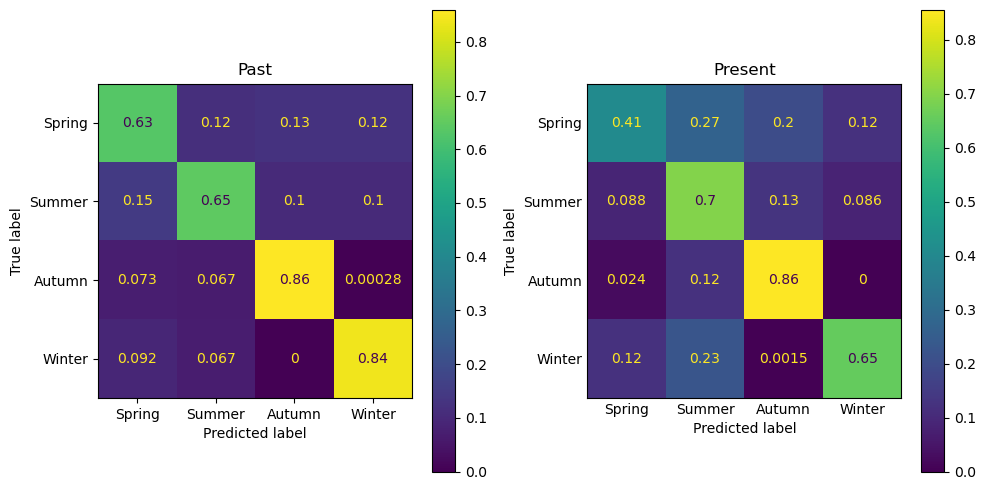

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].set_title("Past")
ax[1].set_title("Present")
ax[0].grid(False)
ax[1].grid(False)

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_true=y_test, y_pred=prediction.argmax(axis=1), normalize='true'),
display_labels = ['Spring', 'Summer', 'Autumn', 'Winter']).plot(ax=ax[0])
plt.tick_params(axis=u'both', which=u'both',length=0)

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_true=y_current, y_pred=pred_current.argmax(axis=1), normalize='true'),
display_labels = ['Spring', 'Summer', 'Autumn', 'Winter']).plot(ax=ax[1])
plt.tick_params(axis=u'both', which=u'both',length=0)

plt.tight_layout()
plt.show()


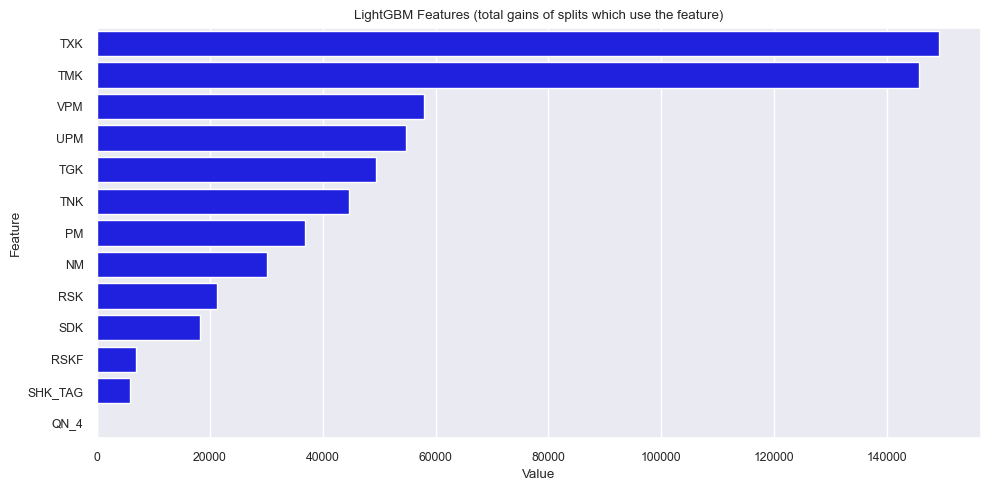

In [15]:
def plotImp(model, X , num = 20, fig_size = (10, 5)):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(importance_type='gain'),
                                'Feature':model.feature_name()})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = .8)
    sns.barplot(x="Value", y="Feature", color='blue', data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (total gains of splits which use the feature)')
    plt.tight_layout()
    plt.show()

plotImp(model, X_train)


<Figure size 2000x1000 with 0 Axes>

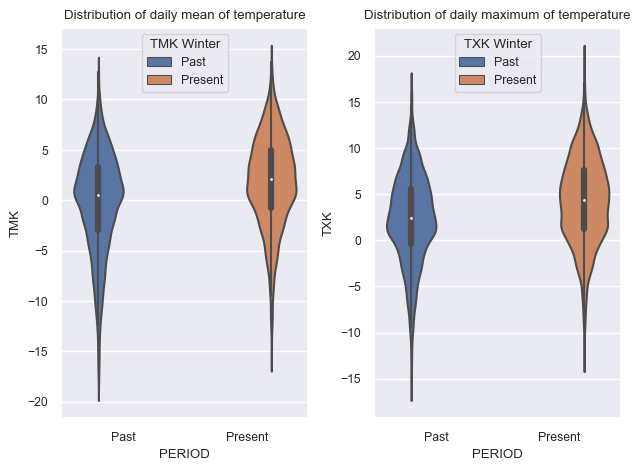

In [24]:
df_past = df_past.assign(PERIOD='Past', YEAR=df_past.MESS_DATUM.dt.year)
df_current = df_current.assign(PERIOD='Present', YEAR=df_current.MESS_DATUM.dt.year)

dp = df_past.loc[df_past.SEASON == 'Winter', ['TMK', 'TXK', 'PERIOD', 'YEAR']]
dc = df_current.loc[df_current.SEASON == 'Winter', ['TMK', 'TXK', 'PERIOD', 'YEAR']]

df_all = pd.concat([dp,dc], axis=0, ignore_index=True)
df_all.reset_index(drop=True)

plt.figure(figsize=(20,10))

fig, axs = plt.subplots(ncols=2)

axs[0].set_title('Distribution of daily mean of temperature')
sns.violinplot(df_all, x=df_all.PERIOD, y=df_all.TMK, hue=df_all.PERIOD, ax=axs[0])
axs[0].legend(loc="upper center", title="TMK Winter", title_fontsize="medium")

axs[1].set_title('Distribution of daily maximum of temperature')
sns.violinplot(df_all, x=df_all.PERIOD, y=df_all.TXK, hue=df_all.PERIOD, ax=axs[1])
axs[1].legend(loc="upper center", title="TXK Winter", title_fontsize="medium")

plt.tight_layout()
plt.show()

<Figure size 2000x1000 with 0 Axes>

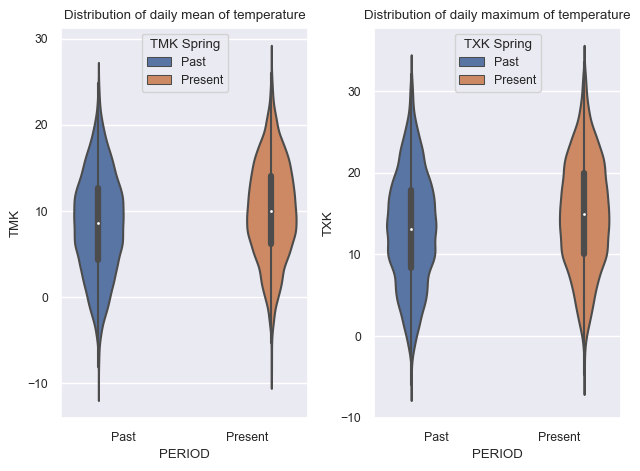

In [23]:
df_past = df_past.assign(PERIOD='Past', YEAR=df_past.MESS_DATUM.dt.year)
df_current = df_current.assign(PERIOD='Present', YEAR=df_current.MESS_DATUM.dt.year)

dp = df_past.loc[df_past.SEASON == 'Spring', ['TMK', 'TXK', 'PERIOD', 'YEAR']]
dc = df_current.loc[df_current.SEASON == 'Spring', ['TMK', 'TXK', 'PERIOD', 'YEAR']]

df_all = pd.concat([dp,dc], axis=0, ignore_index=True)
df_all.reset_index(drop=True)

plt.figure(figsize=(20,10))

fig, axs = plt.subplots(ncols=2)

axs[0].set_title('Distribution of daily mean of temperature')
sns.violinplot(df_all, x=df_all.PERIOD, y=df_all.TMK, hue=df_all.PERIOD, ax=axs[0])
axs[0].legend(loc="upper center", title="TMK Spring", title_fontsize="medium")

axs[1].set_title('Distribution of daily maximum of temperature')
sns.violinplot(df_all, x=df_all.PERIOD, y=df_all.TXK, hue=df_all.PERIOD, ax=axs[1])
axs[1].legend(loc="upper center", title="TXK Spring", title_fontsize="medium")

plt.tight_layout()
plt.show()

In [17]:
dp.describe()

,TMK,TXK,YEAR
count,17329.000000,17329.000000,17329.000000
mean,-0.162594,2.329078,1958.793352
std,4.925654,4.775340,7.628262
min,-18.500000,-16.000000,1940.000000
25%,-3.000000,-0.400000,1953.000000
50%,0.500000,2.400000,1960.000000
75%,3.300000,5.600000,1965.000000
max,12.800000,16.800000,1970.000000


In [18]:
dc.describe()

,TMK,TXK,YEAR
count,11252.000000,11253.000000,11253.000000
mean,1.866104,4.337928,2009.716253
std,4.466968,4.640388,6.383935
min,-15.600000,-12.800000,2000.000000
25%,-0.800000,1.200000,2004.000000
50%,2.100000,4.400000,2009.000000
75%,5.000000,7.600000,2015.000000
max,14.000000,19.700000,2021.000000


<AxesSubplot:>

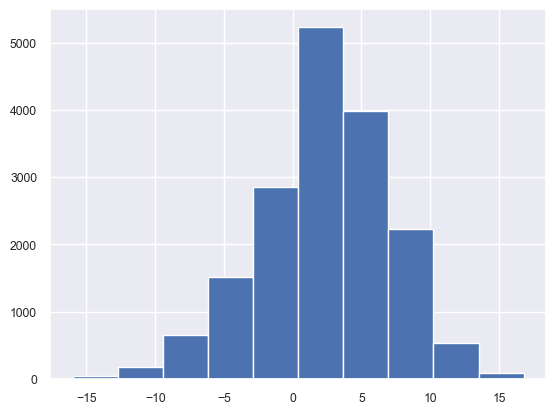

In [36]:
dp.TXK.hist()

<AxesSubplot:>

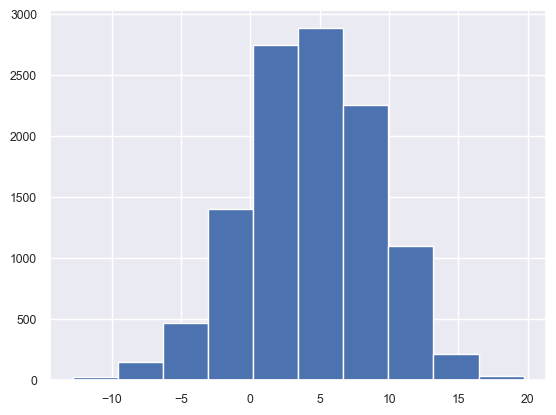

In [41]:
dc.TXK.hist()

In [79]:
from scipy import stats

a = dp['TMK'].to_numpy()
b = dc['TMK'].to_numpy()

c = dp['TXK'].to_numpy()
d = dc['TXK'].to_numpy()

#perform Welch's t-test
# Alternative hypothesis: 'greater’: the mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample.
print(stats.ttest_ind(a=a, b=b, equal_var=False, nan_policy='omit', alternative='two-sided'))
print(stats.ttest_ind(a=c, b=d, equal_var=False, nan_policy='omit', alternative='two-sided'))

Ttest_indResult(statistic=-36.012419916454846, pvalue=4.2395515002239074e-277)
Ttest_indResult(statistic=-35.349268097841815, pvalue=5.140265563705678e-267)


Since this p-value is less than .05, we can reject the null hypothesis of the test and conclude that there is a statistically significant difference in mean temperatures of the two groups.